In [1]:
import pandas as pd
from arango import ArangoClient

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import minmax_scale
import networkx as nx

import plotly.graph_objects as go


import plotly.io as pio
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import minmax_scale
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

import numpy as np
from sklearn.preprocessing import minmax_scale
client = ArangoClient(hosts="http://localhost:8529")
sys_db = client.db('_system', username='root',password='root')
db = client.db("text", username="root", password="root")

## Graphe de co-occurence


In [78]:
pio.renderers.default='browser'

In [ ]:
lemmas_from_sentences = pd.DataFrame(list(db.aql.execute('''for start_vertex in sentences
        for v, e in inbound start_vertex is_from
        filter e.type == 'lemmaToSent'
        collect sent = e._to, lemmas = v.lemma into groups ={
        "sentence" : e._to,
        "lemma" : v.lemma
        }
        return {"sentence":sent,
                "lemma":lemmas}
                '''))).groupby('sentence')['lemma'].apply(' '.join)

vectorizer = CountVectorizer(min_df=10)

termDocMatrix  = vectorizer.fit_transform(lemmas_from_sentences)

coOccurenceMatrix = termDocMatrix.T.dot(termDocMatrix)
# retire les liens d'un nodeà lui même dnas la matrice

coOccurenceMatrix.setdiag(0)

# construction du graphe
G = nx.from_scipy_sparse_array(coOccurenceMatrix,
                                parallel_edges=False)

# retire les arretes qui connectent un noeud à lui même 

G.remove_edges_from(nx.selfloop_edges(G))



# définition de la position des noeuds par spatialisation fruchterman reingold

FRL = nx.drawing.layout.fruchterman_reingold_layout(G)

# kamada kawai
# KMK = nx.drawing.layout.kamada_kawai_layout(G)

for i in range(0,len(FRL)):
    G.nodes[i]['pos'] = FRL[i]
    


def make_edge(x, y, width,scaledWidth):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter(
                x=x,
                y=y,
                line=dict(width=width,color='#888'),
                hoverinfo='none',
                mode='lines',
                opacity=scaledWidth)




xTupleList = []
yTupleList = []

for ed in G.edges(): 
    xfrom = G.nodes()[ed[0]]['pos'][0]
    yfrom = G.nodes()[ed[0]]['pos'][1]
    
    xto = G.nodes()[ed[1]]['pos'][0]
    yto = G.nodes()[ed[1]]['pos'][1]
    xTupleList.append((xfrom,xto,None))
    yTupleList.append((yfrom,yto,None))

widthList = np.array([G.edges[ed]['weight'] for ed in G.edges()])

scaledWidthList = minmax_scale(widthList)



edge_trace = [make_edge(x,y,w,sw) for x,y,w,sw in zip(xTupleList,yTupleList,widthList*0.5,scaledWidthList)]




node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    
    
    

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text='text',
    textposition='top center',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title="Nombre d'occurences",
            xanchor='left',
            titleside='right'
        ),
        line_width=2))




node_trace.marker.color = list(vectorizer.vocabulary_.values())
node_trace.text = list(vectorizer.vocabulary_.keys())


layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)


fig = go.Figure(layout = layout)

# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)# Add node trace
fig.add_trace(node_trace)# Remove legend
fig.update_layout(showlegend = False)

## visualisation de relations syntagmatiques

In [2]:
def get_syntagmatic_data(word):
    data = pd.DataFrame(list(db.aql.execute(f'''
    for token in tokens
    filter token.token == '{word}'
    let selected_token = token._id

    for v, e in 1..1 
    any selected_token
    syntagmatic_link
    filter e.dep_relation != 'ROOT'

    return {{"token": v.token,
            "relation" : e.dep_relation,
            "from_sentence" : e.from_sentence_number,
            "head_pos_tag" : e.head_pos_tag
            }}


                    ''')))    
    
    # à remplacer avec une requette donnant le titre du document
    if data.shape == (0,0):
        return "Mot non trouvé"
    else :
        data['doc'] = data['from_sentence'].str.extract('(doc\d+)')
        return data

In [3]:
def make_edge(x, y, width,scaledWidth):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter(
                x=x,
                y=y,
                line=dict(width=width,color='#888'),
                hoverinfo='none',
                mode='lines',
                opacity=scaledWidth)

# todo :
- ajouter dans full edgelist des données pour : 
    - donner les informations sur combien de fois le mot est apparu en hover
- extraire le titre du document pour l'insérer dans le graphe

In [4]:
def plot_word_of_interest(word_of_interest):
    
# récupération table de relations syntagmatiques depuis la db
    syntagmatic_data = get_syntagmatic_data(word_of_interest)
    
    if type(syntagmatic_data) == str :
        return syntagmatic_data
    else:
        
        size_of_interest = 10

        syntagmatic_data = syntagmatic_data.sort_values('from_sentence')
    # ajout d'un 1 pour calculer les fréquences par aggrégation
        syntagmatic_data['count'] = 1

        # construction d'une edgelist pour créer le graphe
        edgelist = syntagmatic_data.groupby(['token','doc']).aggregate('sum')
        # l'index est multiple, on l'applatit
        edgelist = pd.DataFrame(edgelist.to_records())

        edgelist.rename(columns={"token":'from',
                                      'doc':'to'}, inplace=True)
        # on calcule la fréquence sur le lien racine / document
        edgelist_token_doc = pd.DataFrame(edgelist.groupby('to').aggregate('sum').to_records())
        edgelist_token_doc['from'] = word_of_interest

        # concaténation des docs et mots en une edgelist
        full_edgelist = pd.concat([edgelist, edgelist_token_doc])

        # création du graphe et calcul de la spatialisation
        G = nx.from_pandas_edgelist(full_edgelist,'from','to',edge_attr='count')
        KKL = nx.drawing.layout.kamada_kawai_layout(G)

        # insertion de la spatialisation pour la construction des arrêtes
        x_from_to = []
        y_from_to = []
        for from_vertex, to_vertex in zip(full_edgelist['from'], full_edgelist['to']):
            x_from_to.append((KKL[from_vertex][0], KKL[to_vertex][0]))
            y_from_to.append((KKL[from_vertex][1], KKL[to_vertex][1]))

        full_edgelist['from_and_to_x'] = x_from_to
        full_edgelist['from_and_to_y'] = y_from_to
        full_edgelist.reset_index(inplace=True,drop=True)

        # construction d'une échelle allant de 0.1 à 1 pour la transparence et épaisseur des arrêtes
        mask = full_edgelist['from'] == word_of_interest
        indexes_root_word, indexes_doc_words = full_edgelist[mask].index, full_edgelist[~mask].index

        full_edgelist.loc[indexes_root_word,'adjusted_count'] = minmax_scale(full_edgelist['count'][indexes_root_word]) +1
        full_edgelist.loc[indexes_doc_words,'adjusted_count'] = minmax_scale(full_edgelist['count'][indexes_doc_words]) +1

        # Sans le +0.1 le minmax donne 0 et donc pas de ligne. Si on ajout 0.1 on sort du range 0 - 1 autorisé par la valeur de transparence

        full_edgelist['opacity'] = minmax_scale(full_edgelist['adjusted_count'])+0.1
        full_edgelist['opacity'] = full_edgelist['opacity'].clip(upper=1)

        # création de la disposition des arrêtes
        edge_trace = [make_edge(x,y,w,sw) for x,y,w,sw in zip(full_edgelist['from_and_to_x'],
                                                              full_edgelist['from_and_to_y'],
                                                              full_edgelist['adjusted_count'],
                                                              full_edgelist['opacity'])]

        # Disposition des noeuds
        df_KKL = pd.DataFrame(KKL).T
        df_KKL.columns = ['x','y']

        # coloration en fonction du mot racine, document et mot relié

        df_KKL['color'] = 'rgb(255,102,102)'

        df_KKL.loc[word_of_interest,'color'] = 'rgb(0,204,0)'


        # A MODIFIER : besoin d'un filtre capable de repérer les documents finit par .txt ? 
        mask_doc = df_KKL.index.str.match('(doc)')




        df_KKL.loc[df_KKL.index[mask_doc],'color'] = 'rgb(0,128,255)'
        
        ######
        # faire un merge de ces infos sur df_KKL et ajouter le word of interest avec une tailel arbitraire
        ######
        doc_count = syntagmatic_data.groupby('doc').sum('count')
        doc_count['count'] =( minmax_scale(doc_count['count']) +1) *5
        token_count = syntagmatic_data.groupby('token').sum('count')
        token_count['count'] = (minmax_scale(token_count['count']) +1) *5

        df_count = pd.concat([doc_count,token_count,pd.DataFrame({'count':[size_of_interest]},index=[word_of_interest])])
        
        df_KKL = df_KKL.join(df_count)
        node_trace = go.Scatter(
        x=df_KKL['x'], y=df_KKL['y'],
        mode='markers+text',
        textposition='top center',
        marker_color=df_KKL['color'],
        marker_size=df_KKL['count'])
        node_trace.text = df_KKL.index

        fig = go.Figure()
        for trace in edge_trace:
            fig.add_trace(trace)# Add node trace
        fig.add_trace(node_trace)
        # Remove legend
        fig.update_layout(showlegend = False)
        return fig

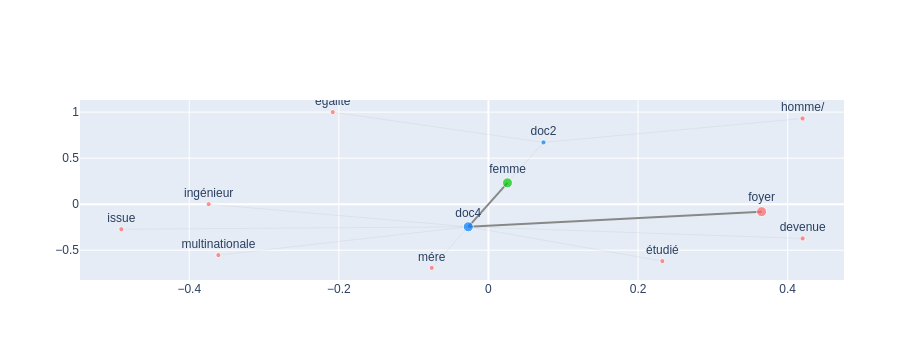

In [38]:
plot_word_of_interest('femme')

## Concordancier

In [28]:
get_syntagmatic_data('emploi')

,token,relation,from_sentence,head_pos_tag,doc
0,différencié,acl,doc1sent42,NOUN,doc1
1,termes,nmod,doc1sent42,NOUN,doc1
2,indice,nmod,doc1sent222,NOUN,doc1
3,développement,conj,doc2sent192,NOUN,doc2
4,territoires,conj,doc2sent192,NOUN,doc2
...,...,...,...,...,...
128,succéde,nsubj,doc4sent606,VERB,doc4
129,perd,nsubj,doc4sent609,VERB,doc4
130,appréhender,obj,doc4sent623,VERB,doc4
131,pourraient,obj,doc4sent630,VERB,doc4


In [18]:
test_sent = list(db.aql.execute('''
    FOR sent in sentences
    FILTER sent._key == 'doc4sent623'
    RETURN sent.content
'''))[0]

In [9]:
import matplotlib.pyplot as plt
from matplotlib import transforms


def rainbow_text(x, y, strings, colors, ax=None, **kw):
    """
    Take a list of ``strings`` and ``colors`` and place them next to each
    other, with text strings[i] being shown in colors[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.

    The text will get added to the ``ax`` axes, if provided, otherwise the
    currently active axes will be used.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas
    ax.axis('off')
    # horizontal version
    for s, c in zip(strings, colors):
        text = ax.text(x, y, " " + s + " ", color=c, transform=t, **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

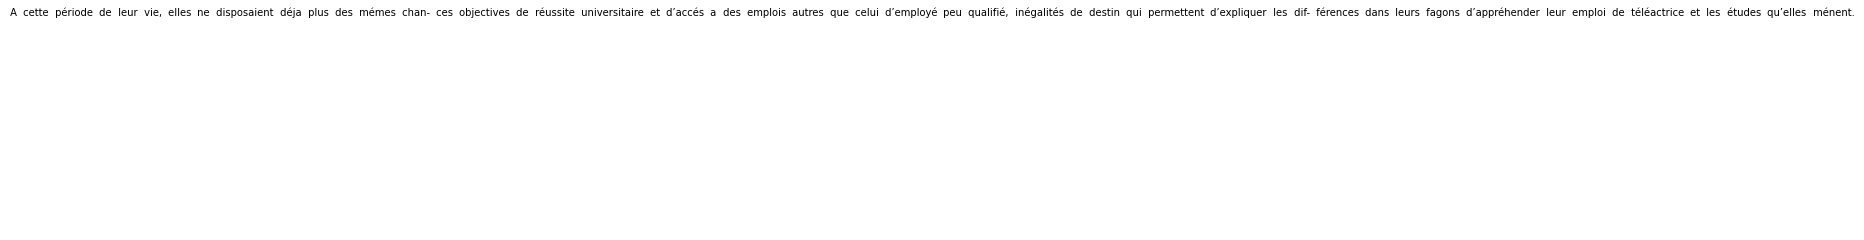

In [32]:
rainbow_text(0,1,test_sent.split(),('black ' * 52).split() )

In [20]:
len(test_sent.split())

In [34]:
('black ' * 52).split()

In [35]:
test_sent

'A cette période de leur vie, elles ne disposaient déja plus des mémes chan- ces objectives de réussite universitaire et d’accés a des emplois autres que celui d’employé peu qualifié, inégalités de destin qui permettent d’expliquer les dif- férences dans leurs fagons d’appréhender leur emploi de téléactrice et les études qu’elles ménent.'

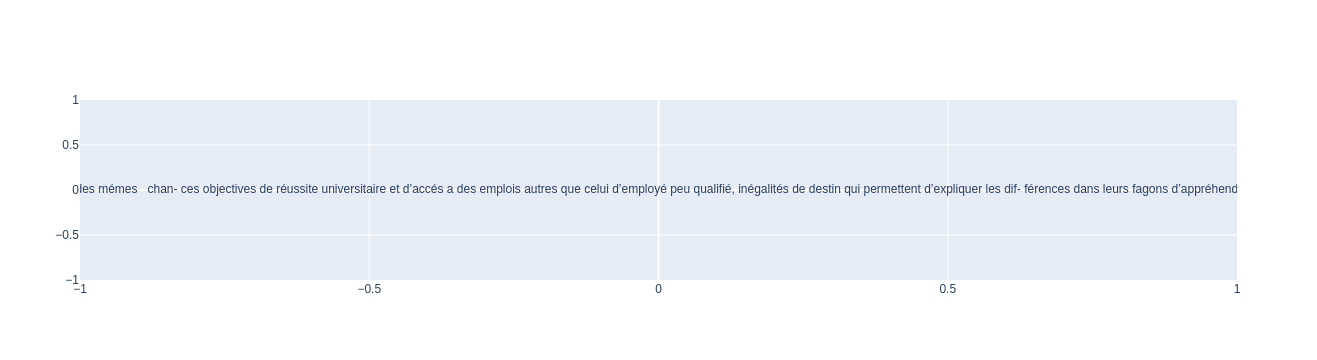

In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = [0],
    y = [0],
    mode = 'text',
    text='A cette période de leur vie, elles ne disposaient déja plus des mémes \r chan- ces objectives de réussite universitaire et d’accés a des emplois autres que celui d’employé peu qualifié, inégalités de destin qui permettent d’expliquer les dif- férences dans leurs fagons d’appréhender leur emploi de téléactrice et les études qu’elles ménent.'))